In [ ]:
! pip install numpy torch torchvision pytorch-ignite tensorboardX tensorboard
!pip install keras

     |████████████████████████████████| 184kB 5.9MB/s 
     |████████████████████████████████| 317kB 36.7MB/s 


# New section

In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
import csv
import seaborn as sns
import matplotlib.pyplot as plt

 
directory = "images"
original_images = []
target = []
class_samples = []
class_names = os.listdir(directory)
 
############## Methods for loading images, showing class distribution and saving data as csv #############
 
def load_original_images():
    for i, class_name in enumerate(class_names):
        img_names = os.listdir(directory + "/" + class_name)
        class_samples.append(len(img_names))
        for j, img_name in enumerate(img_names):
            img = cv2.imread(directory + "/" + class_name + "/" + img_name, 0)
            img_resized = cv2.resize(img, (50, 50)) 
            ret, img_binarised = cv2.threshold(img_resized, 127, 255, cv2.THRESH_BINARY)
            # Storing images as 2D arrays
            original_images.append(img_binarised)
            # Storing class names as targets
            target.append(class_name)
    return original_images
 
def show_class_distribution(target):
    print('\nCalculating class distribution...')
    histo = [['Class','Number of Samples']]
    for i, label1 in enumerate(sorted(list(set(target)))):
        cont = 0
        for j, label2 in enumerate(target):
            if label1 == label2:
                cont+=1
        histo.append([label1,cont])
    df = pd.DataFrame.from_records(histo[1:], columns = histo[0])
    ## Create a histogram using seaborn
    sns_plot = sns.barplot(y="Class", x="Number of Samples", data = df)
    sns_plot.figure.set_size_inches(24, 24)
    print('Showing class distribution...')
    plt.show()
 
def save_dataset_as_csv(dataset, filename):
    data = dataset['data']
    target = dataset['target']
    print('\nSaving dataset to file: ' + filename + '.csv')
    
    with open(filename + '.csv', 'w', newline='', encoding='utf-8') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',')
        for i, pix in enumerate(data):
            row = np.concatenate((pix,[target[i]]))
            filewriter.writerow(row)
    print('Successfully saved')

Total number of classes:  5

Calculating class distribution...
Showing class distribution...


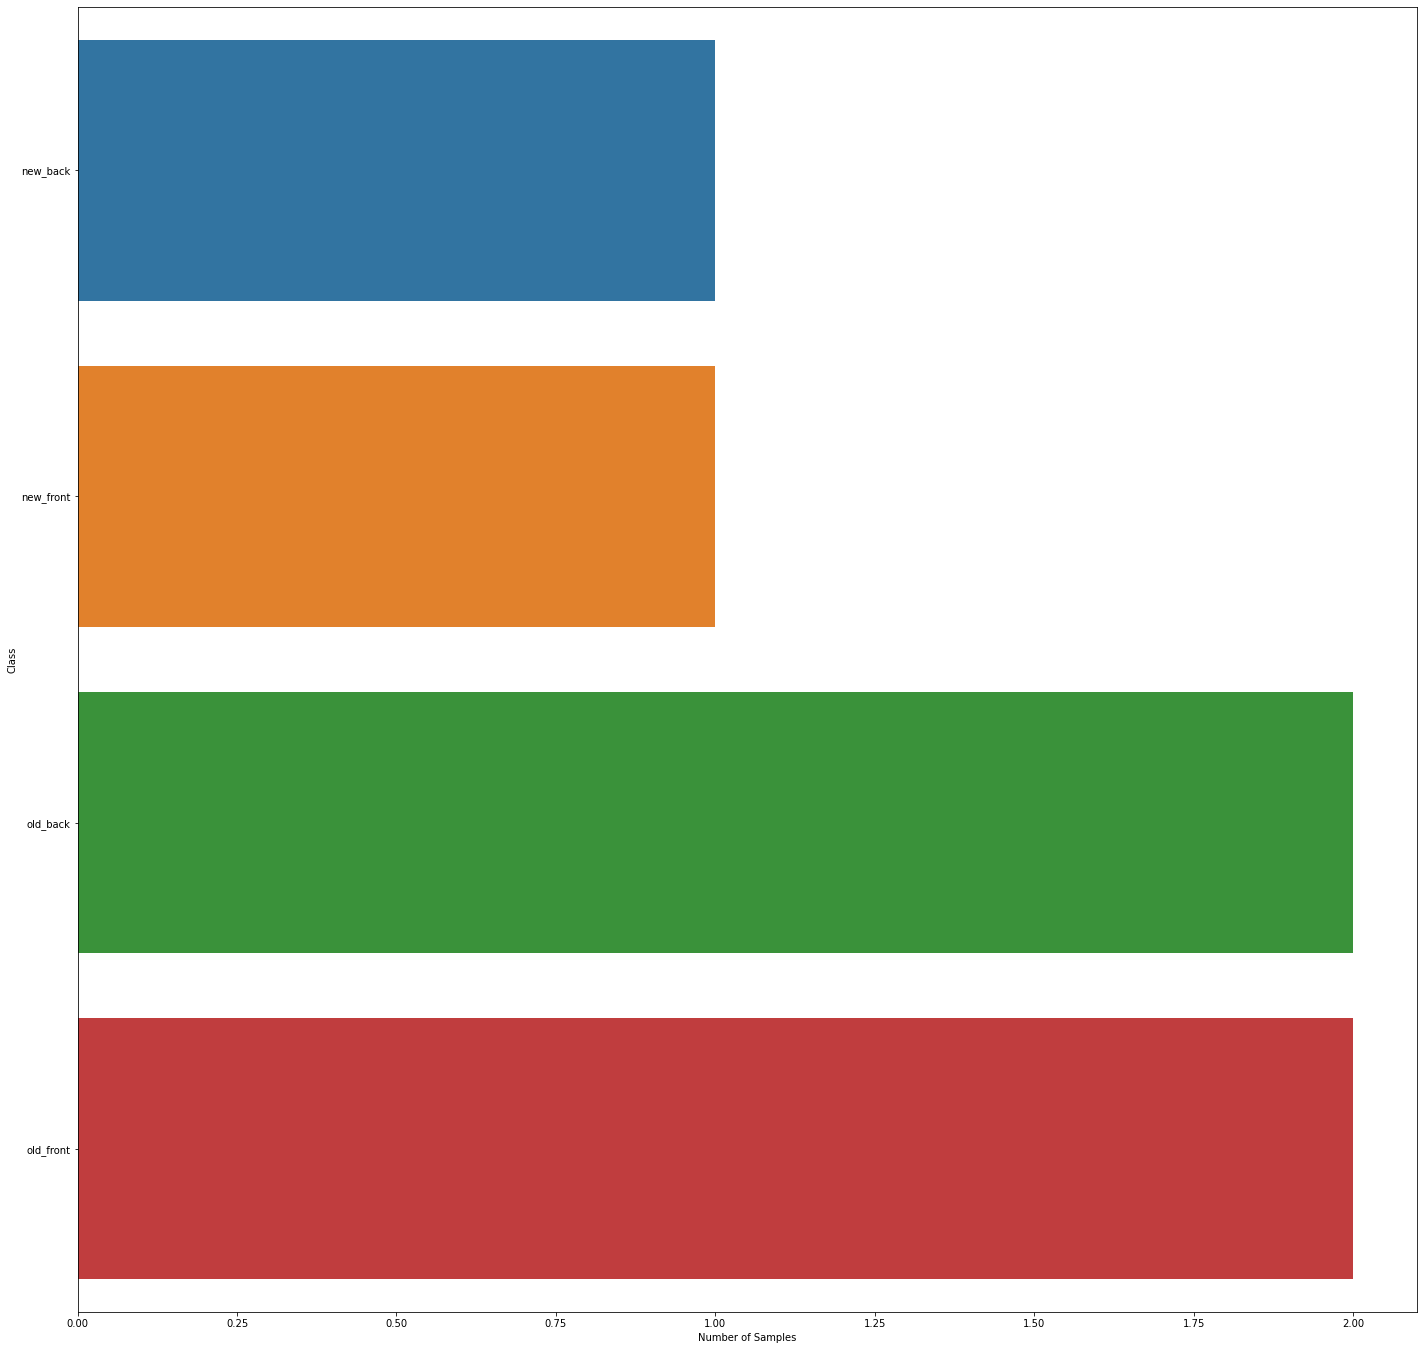

In [ ]:
# Initial step of loading images from the directory
load_original_images()
print('Total number of classes: ', len(class_samples))
show_class_distribution(target)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
 
################## Methods used to implement image augmentation with Tensorflow ########################
 
def rotate(x: tf.Tensor) -> tf.Tensor:
    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
 
def flip(x: tf.Tensor) -> tf.Tensor:
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return x
 
def zoom(x: tf.Tensor) -> tf.Tensor:
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))
 
    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]
 
    def random_crop(img):
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(50, 50))
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]
 
    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))
 
def plot_images(dataset, n_images, samples_per_image):
    output = np.zeros((50 * n_images, 50 * samples_per_image, 3))
    row = 0
    for images in dataset.repeat(samples_per_image).batch(n_images):
        output[:, row*50:(row+1)*50] = np.vstack(images.numpy())
        row += 1
    plt.figure()
    plt.imshow(output)
    plt.show()
    return
 
def augment_images(class_images, targets, images_required):
    samples_per_image = math.ceil(images_required / len(class_images['data'])) 
    imgs = tf.data.Dataset.from_tensor_slices((class_images['data'] / 255).astype(np.float32))
    # Apply augmentation techniques
    augmentations = [rotate, flip, zoom]
    for f in augmentations:
        imgs = imgs.map(f, num_parallel_calls=1)
    
    # Iterate through images generated by Tensorflow until we get the required number of  
    # new images in order to have a balanced dataset
    for images in imgs.repeat(samples_per_image).batch(len(class_images['data'])):
        for image in images.numpy():
            class_images['data'] = np.vstack((class_images['data'], [image]))
            class_images['target'] = np.append(class_images['target'], targets)
            if len(class_images['data']) == images_required:
                return class_images['data'], class_images['target']

In [ ]:
################## Applying Augmentation ########################
 
classes = os.listdir("images")
repo_augmented = {}
repo_augmented['target'] = np.array([])
 
max_sample_count = max(class_samples)
print('Class ' + class_names[class_samples.index(max_sample_count)] 
      + ' has the maximum number of images: ' + str(max_sample_count))
 
print('Augmenting other classes...\n')
 
for i, className in enumerate(classes):
    images = os.listdir("images/" + className)   
    class_images = {}
    class_images['data'] = None
    class_images['target'] = np.array([])
    
    for j, image in enumerate(images):
        img = cv2.imread("images/" + className + "/" + image, 0)
        img_resize = cv2.resize(np.atleast_3d(img), (50, 50)) 
        # Convert data to arrays with 3 dimensions since Tensorflow needs at least 3 dimensions
        img_resize = np.atleast_3d(img_resize)
        if j == 0:
            class_images['data'] = np.array([img_resize.copy()])
        else: 
            class_images['data'] = np.vstack((class_images['data'], [img_resize]))
        class_images['target'] = np.append(class_images['target'], className)
 
    # Deciding which classes to augment based on maximum number of samples per class
    if (class_samples[i] < max_sample_count):
        print('Augmenting class ' + class_names[i] + '...')
        # Start Tensorflow image augmentation process
        class_images['data'], class_images['target'] = augment_images(class_images, className, max_sample_count)
        print(len(class_images['data']) - class_samples[i], 'new images generated', '\n')
    if i == 0:
        repo_augmented['data'] = class_images['data'].copy();
    else:
        repo_augmented['data'] = np.vstack((repo_augmented['data'], class_images['data']))
    repo_augmented['target'] = np.append(repo_augmented['target'], class_images['target'])
        
# Reshaping 2D images in to image vectors before writing data to csv file        
repo_augmented['data'] = repo_augmented['data'].reshape(len(repo_augmented['data']), 50, 50)
repo_augmented['data'] = repo_augmented['data'].reshape(len(repo_augmented['data']), 2500)
 
print('Size of augmented pixel repository:', repo_augmented['data'].shape)
print('Size of target:', len(repo_augmented['target']))
print('\nAugmented pixel repository:\n', repo_augmented)
 
# Showing class distribtion with augmented images
show_class_distribution(repo_augmented['target'])
# Saving image data as a csv file
save_dataset_as_csv(dataset = repo_augmented, filename = 'augmented_pixel_repository')

Class old_back has the maximum number of images: 2
Augmenting other classes...

Augmenting class new_back...
1 new images generated 

Augmenting class .ipynb_checkpoints...


TypeError: ignored

In [ ]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn import datasets, svm, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
 
################## Methods used to evaluate model ########################
 
# Performance matrics to be used to evaluate experiments
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
 
def split_data_target(dataset):
    nrows = dataset.shape[0]
    ncols = dataset.shape[1]
    data = dataset.iloc[0:nrows, 0:ncols-1].values
    target = dataset.iloc[:, ncols-1:ncols].values.ravel()
    return data, target
 
def evaluate(results):
    print('\naccuracy:', round(np.mean(results['test_accuracy']), 4))
    print('precision_macro:', round(np.mean(results['test_precision_macro']), 4))
    print('recall_macro:', round(np.mean(results['test_recall_macro']), 4))
    if ('test_f1_macro' in results.keys()):
        print('f1_macro:', round(np.mean(results['test_f1_macro']), 4))
    accuracy = str(round(np.mean(results['test_accuracy']) * 100, 2)) + '%'
    return accuracy

In [ ]:
import numpy as np
import pandas as pd
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import tensorflow as tf
from tensorflow import random

################## CNN implementation ########################

def create_model(no_of_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (50, 50, 1)), 
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(no_of_classes, activation=tf.nn.softmax)
    ])
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def apply_cnn(dataset):
    data, target = split_data_target(dataset)
    data = data.reshape(len(data), 50, 50, 1)
    random.set_seed(1)
    model = KerasClassifier(build_fn = create_model, no_of_classes = len(np.unique(target)), epochs = 20, batch_size = 128, verbose = 1)
    kfold = StratifiedKFold(n_splits = 2, shuffle = True, random_state = 1)
    results = cross_validate(model, data, target, cv = kfold, scoring = scoring)
    return evaluate(results)

In [ ]:
# Load pixel data from the csv file 
augmented_pixel_repo = pd.read_csv('augmented_pixel_repository.csv', delimiter=',', header = None)
print('\nAugmented pixel repo:\n', augmented_pixel_repo.head())

FileNotFoundError: ignored

In [ ]:
# Train CNN using pixel data
apply_cnn(dataset = augmented_pixel_repo)

NameError: ignored